In [1]:
%matplotlib widget

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from tqdm.notebook import tqdm

In [14]:
def make_clouds(num_samples, all_means, all_stds, num_features = 2):
    
    all_samples, all_labels = [], []
    for i, (mean, std) in enumerate(zip(all_means, all_stds)):
       
        all_samples.append(np.random.normal(mean, std, (num_samples, num_features)))
        all_labels.append([i] * num_samples)
        
    return np.vstack(all_samples), np.hstack(all_labels)

# Create visualization of dataset

def show_data(all_samples, all_labels):
    
    plt.style.use("seaborn")
    
    fig, ax = plt.subplots()
    ax.scatter(all_samples[:, 0], all_samples[:, 1], c = all_labels, cmap = "Set2")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_title("Two Linearly Separable Classes")
    fig.tight_layout()

(2000, 2) (2000,) 2


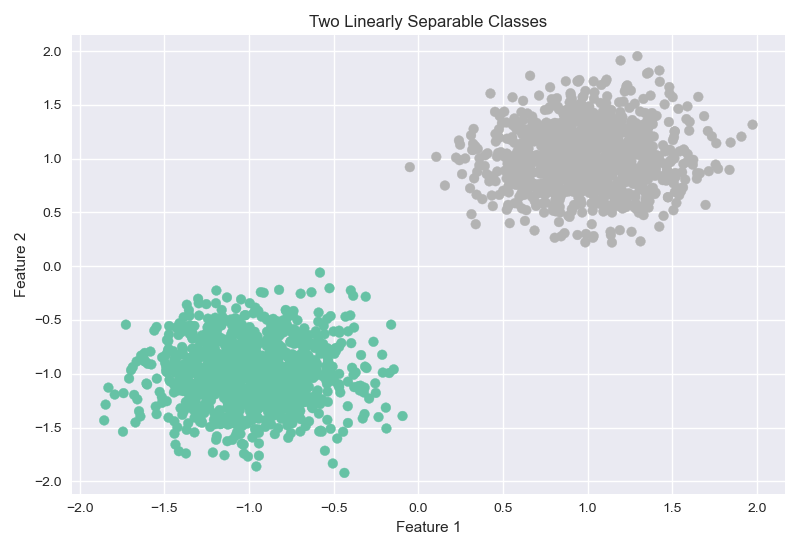

In [15]:
num_samples = 1000
all_means = [(-1, -1), (1, 1)]
all_stds = np.full(len(all_means), 0.3)

num_features = len(all_means[0])

all_samples, all_labels = make_clouds(num_samples, all_means, all_stds, num_features)

num_classes = len(np.unique(all_labels))

print(all_samples.shape, all_labels.shape, num_classes)

show_data(all_samples, all_labels)

In [11]:
# Format dataset for pytorch

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, samples, labels):
        
        super(Dataset, self).__init__()
        
        self.create_dataset(samples, labels)
        
    def create_dataset(self, all_samples, all_labels):
        
        self.dataset = []
        
        for sample, label in zip(all_samples, all_labels):
            self.dataset.append((torch.tensor(sample).float(), torch.tensor(label).long()))
            
    # override a few methods

    def __getitem__(self, index):
                                        
        return self.dataset[index]                            
        
    def __len__(self):
        
        return len(self.dataset)

In [12]:
batch_size = 16  # we're doing minibatch

train_dataset = Dataset(all_samples, all_labels)
valid_dataset = Dataset(all_samples, all_labels) #resubstitution-> only show one time as a proof of concept

train_dataset = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataset = torch.utils.data.DataLoader(valid_dataset, batch_size = 1, shuffle = False)

In [13]:
# Create Network

class MLP(torch.nn.Module):
    
    def __init__(self, learning_rate, num_features, num_classes):
    
        super(MLP, self).__init__()
    
        self.alpha = learning_rate
        
        self.network = torch.nn.Sequential(torch.nn.Linear(num_features, 128),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(128, 64),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(64, num_classes))
        
    def init_optimizer(self):

        self.optimizer = torch.optim.SGD(self.parameters(), lr = self.alpha)
        #self.optimizer = torch.optim.Adam(self.parameters(), lr = self.alpha)

    def objective(self, preds, labels):

        obj = torch.nn.CrossEntropyLoss()

        return obj(preds, labels)

    def forward(self, x):

        return self.network(x)
        
model = MLP(1e-3, num_features, num_classes)